[viz] No data for benchmark: cassandra
[viz] No data for benchmark: h2o
[viz] No data for benchmark: tradebeans
[viz] No data for benchmark: tradesoap


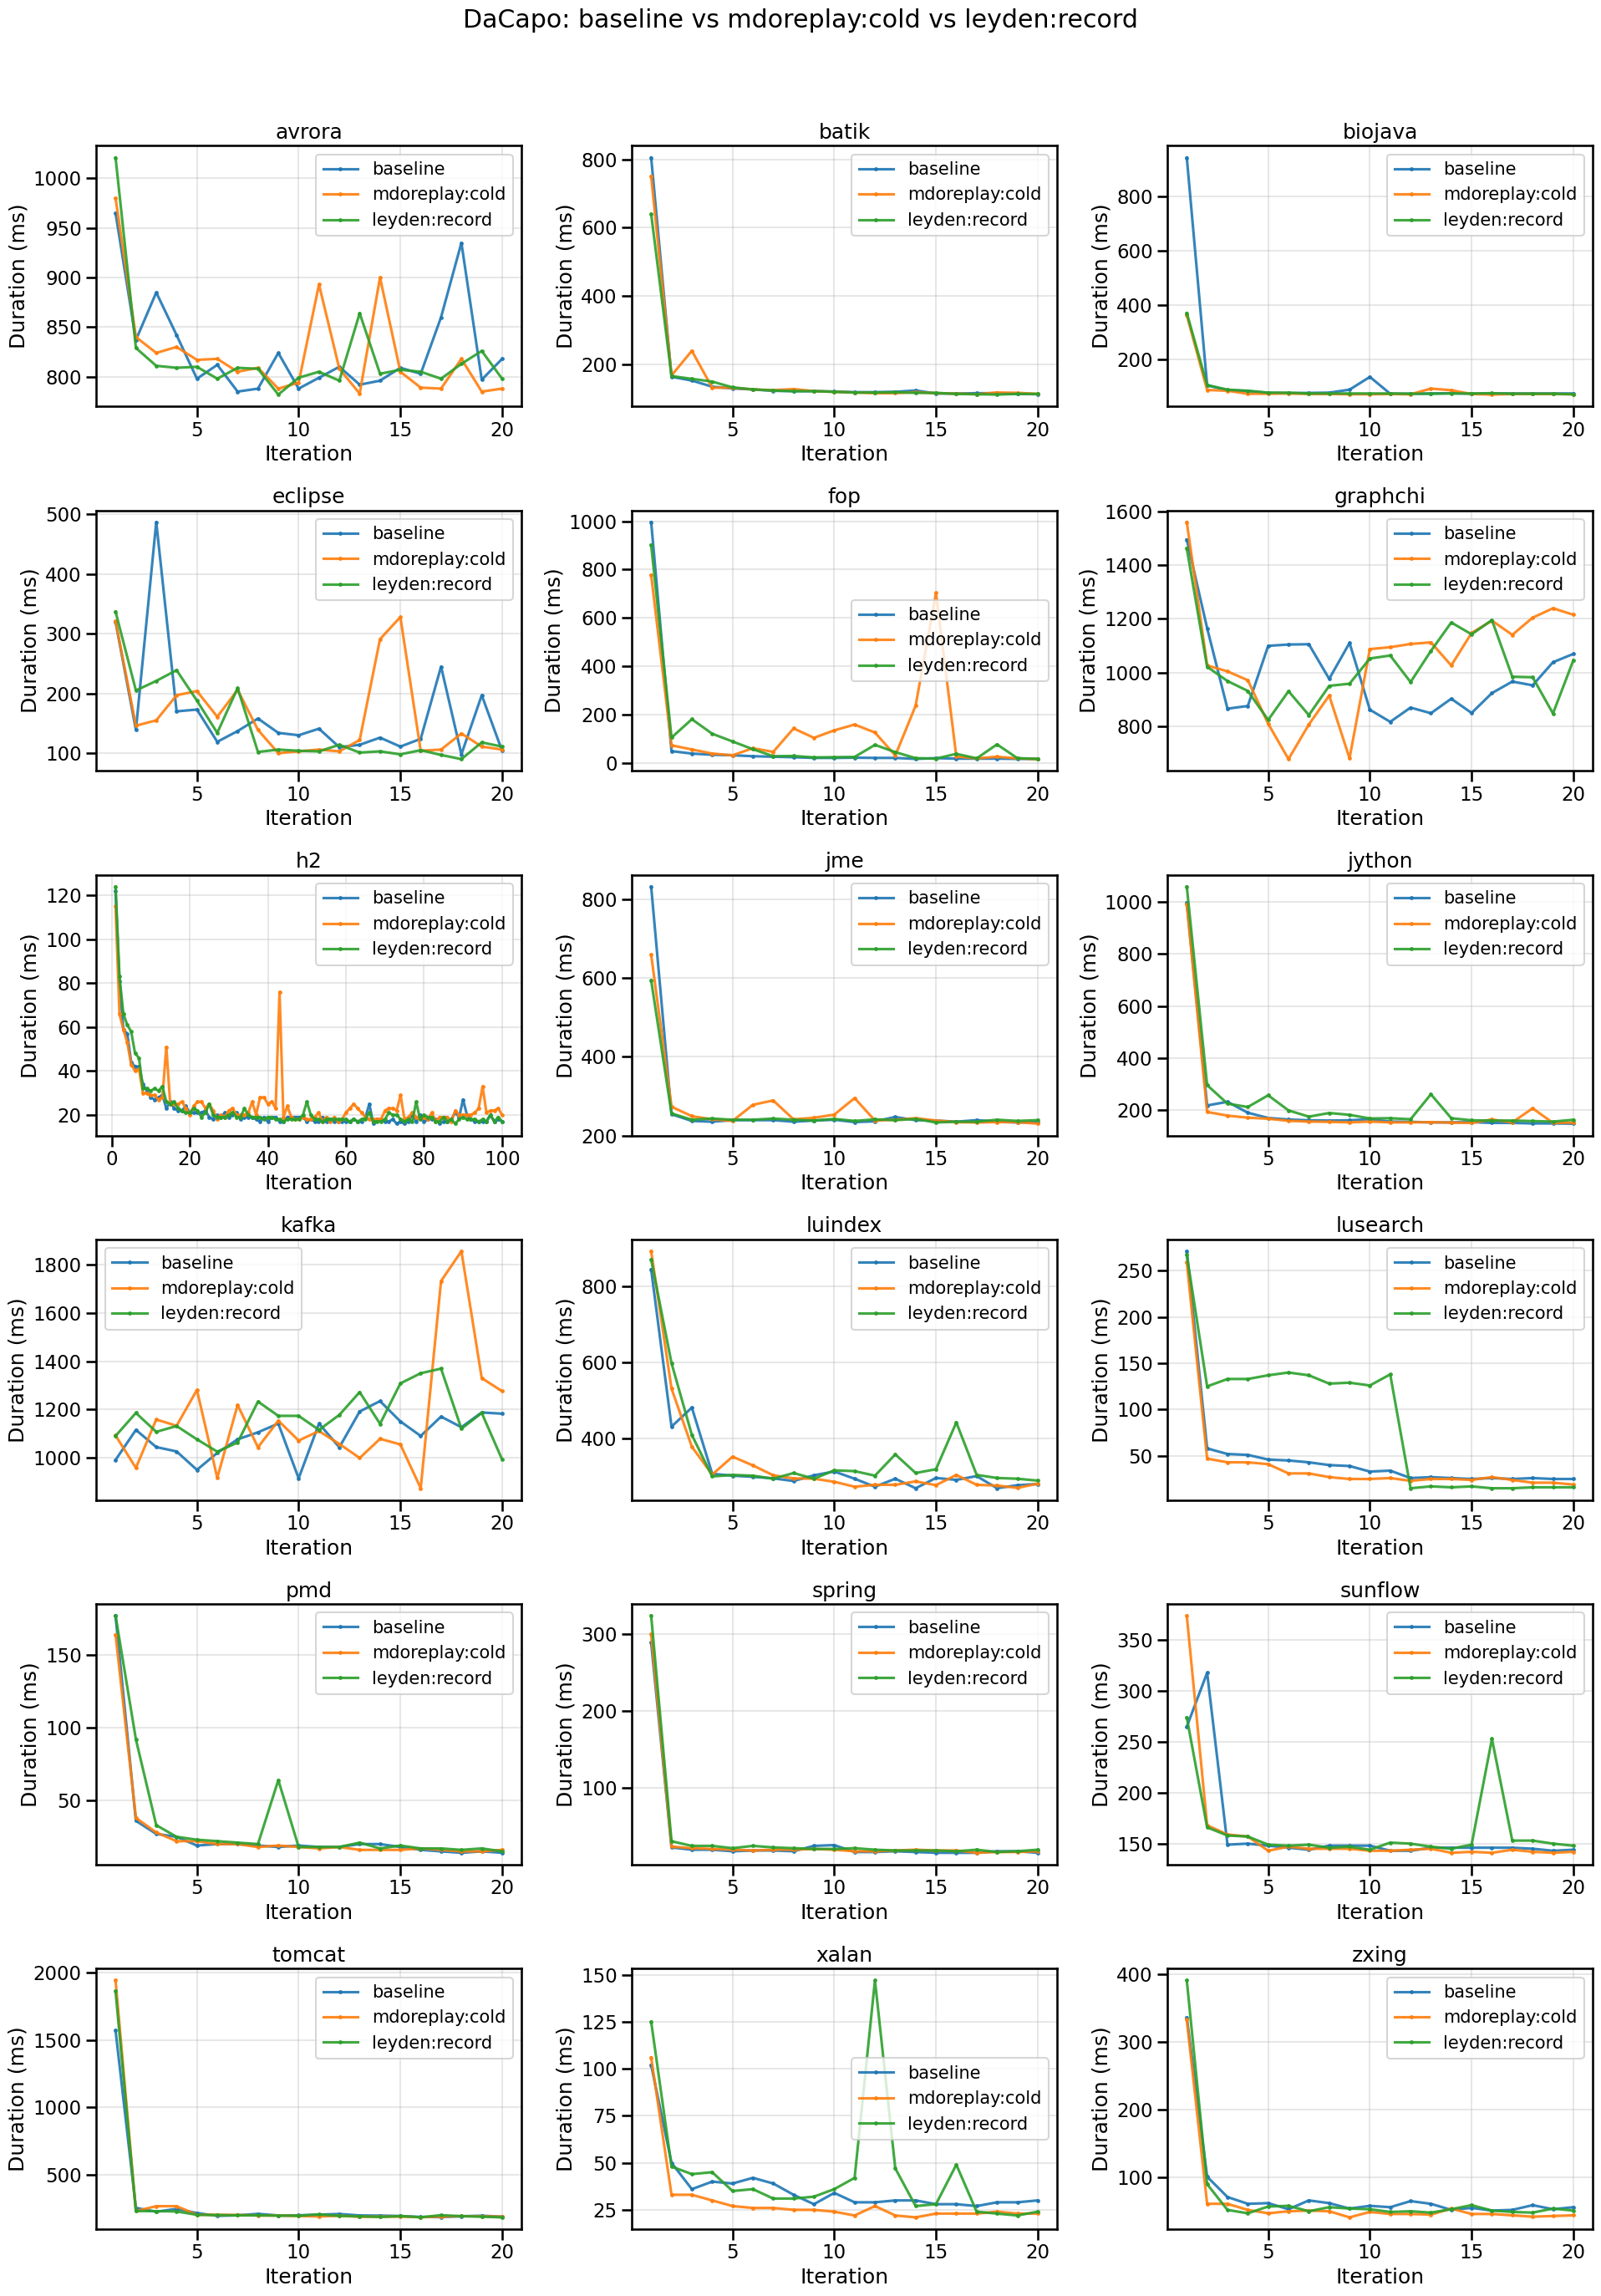

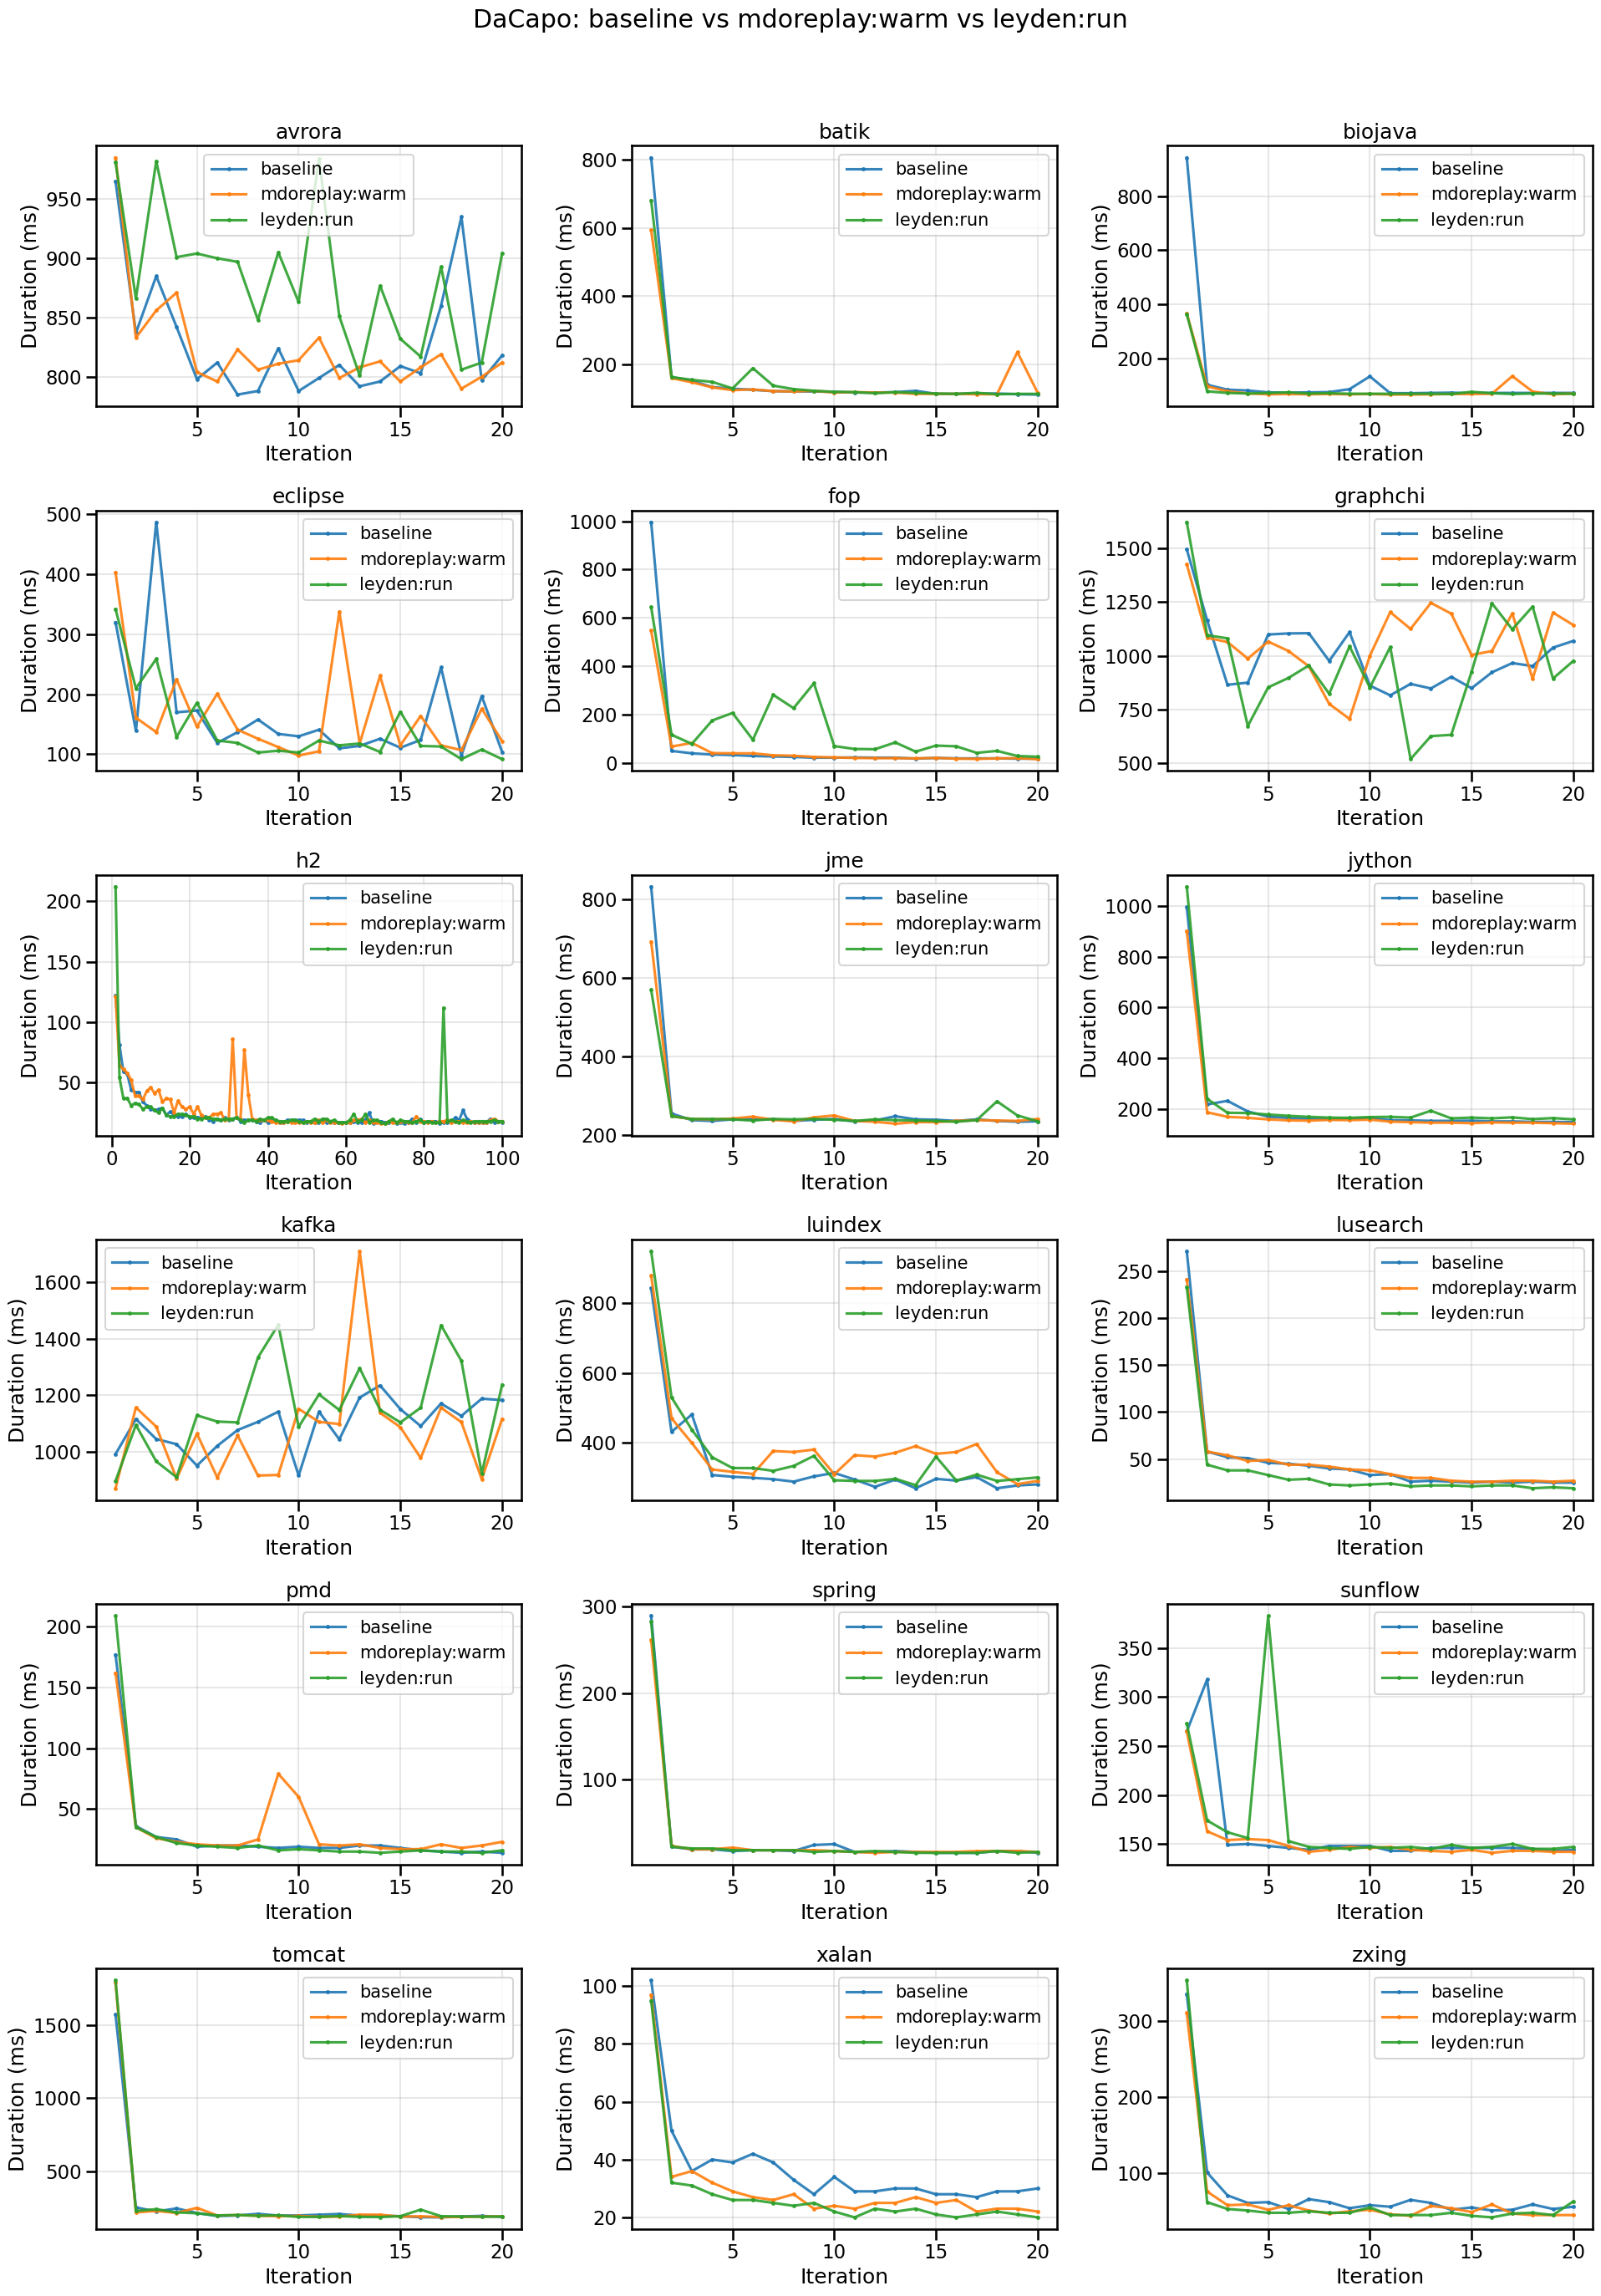

In [5]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')

# Root where run_all.py wrote results
out_root = Path('/Users/georgezhou/personal/research/serverless-jit/bench/dacapo/out')
if not out_root.exists():
    raise FileNotFoundError(f'Missing output directory: {out_root}')

# Collect benches (ignore stray files)
benches = sorted([p.name for p in out_root.iterdir() if p.is_dir()])

# Desired line order per plot
series_order = [
    ('baseline', 'run'),
    ('mdoreplay', 'cold_dump'),
    ('mdoreplay', 'warm_load'),
    ('leyden', 'record'),
    ('leyden', 'run'),
]
label_map = {
    ('baseline', 'run'): 'baseline',
    ('mdoreplay', 'cold_dump'): 'mdoreplay:cold',
    ('mdoreplay', 'warm_load'): 'mdoreplay:warm',
    ('leyden', 'record'): 'leyden:record',
    ('leyden', 'run'): 'leyden:run',
}

# Helper to load and aggregate one bench
def load_bench_df(bench: str) -> pd.DataFrame:
    bdir = out_root / bench
    frames = []
    for wf in ['baseline', 'mdoreplay', 'leyden']:
        f = bdir / f'{wf}.csv'
        if not f.exists():
            continue
        try:
            df = pd.read_csv(f)
        except Exception:
            continue
        # Normalize required columns and types
        required_cols = {'suite','bench','workflow','phase','repeat','iteration','duration_ms'}
        if not required_cols.issubset(set(df.columns)):
            continue
        df = df[['suite','bench','workflow','phase','repeat','iteration','duration_ms']].copy()
        # Normalize workflow naming: run.sh uses "default" for baseline
        df['workflow'] = df['workflow'].replace({'default': 'baseline'})
        # Average repeats to a single line per (workflow, phase)
        df = (
            df.groupby(['bench','workflow','phase','iteration'], as_index=False)['duration_ms']
              .mean()
        )
        frames.append(df)
    if not frames:
        return pd.DataFrame(columns=['bench','workflow','phase','iteration','duration_ms'])
    return pd.concat(frames, ignore_index=True)

# Load all
per_bench = {b: load_bench_df(b) for b in benches}

# Two figures:
# 1) baseline vs mdoreplay:cold vs leyden:record
# 2) baseline vs mdoreplay:warm vs leyden:run

# Report benches with no data at all
for b in benches:
    dfb = per_bench.get(b)
    if dfb is None or dfb.empty:
        print(f'[viz] No data for benchmark: {b}')

cold_keys = [('baseline','run'), ('mdoreplay','cold_dump'), ('leyden','record')]
warm_keys = [('baseline','run'), ('mdoreplay','warm_load'), ('leyden','run')]

# Helper to check if a bench has at least one series among keys
def bench_has_any(dfb: pd.DataFrame, keys: list[tuple[str,str]]) -> bool:
    if dfb is None or dfb.empty:
        return False
    for k in keys:
        if not dfb[(dfb['workflow'] == k[0]) & (dfb['phase'] == k[1])].empty:
            return True
    return False

# Cold figure
benches_cold = [b for b in benches if bench_has_any(per_bench.get(b), cold_keys)]
if benches_cold:
    n = len(benches_cold)
    cols = 3
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*6.5, rows*4.5), squeeze=False, sharex=False)
    for idx, bench in enumerate(benches_cold):
        ax = axes[idx // cols][idx % cols]
        dfb = per_bench[bench]
        plotted = False
        for key in cold_keys:
            sub = dfb[(dfb['workflow'] == key[0]) & (dfb['phase'] == key[1])]
            if sub.empty:
                continue
            ax.plot(sub['iteration'], sub['duration_ms'], marker='o', ms=2.5, label=label_map.get(key, f'{key[0]}:{key[1]}'), alpha=0.9)
            plotted = True
        ax.set_title(bench)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Duration (ms)')
        ax.grid(True, alpha=0.3)
        if plotted:
            ax.legend(fontsize='small')
        else:
            ax.text(0.5, 0.5, 'no series', ha='center', va='center', transform=ax.transAxes)
    for j in range(n, rows*cols):
        fig.delaxes(axes[j // cols][j % cols])
    plt.suptitle('DaCapo: baseline vs mdoreplay:cold vs leyden:record', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print('[viz] No benches with cold series (baseline/mdoreplay:cold/leyden:record).')

# Warm figure
benches_warm = [b for b in benches if bench_has_any(per_bench.get(b), warm_keys)]
if benches_warm:
    n = len(benches_warm)
    cols = 3
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*6.5, rows*4.5), squeeze=False, sharex=False)
    for idx, bench in enumerate(benches_warm):
        ax = axes[idx // cols][idx % cols]
        dfb = per_bench[bench]
        plotted = False
        for key in warm_keys:
            sub = dfb[(dfb['workflow'] == key[0]) & (dfb['phase'] == key[1])]
            if sub.empty:
                continue
            ax.plot(sub['iteration'], sub['duration_ms'], marker='o', ms=2.5, label=label_map.get(key, f'{key[0]}:{key[1]}'), alpha=0.9)
            plotted = True
        ax.set_title(bench)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Duration (ms)')
        ax.grid(True, alpha=0.3)
        if plotted:
            ax.legend(fontsize='small')
        else:
            ax.text(0.5, 0.5, 'no series', ha='center', va='center', transform=ax.transAxes)
    for j in range(n, rows*cols):
        fig.delaxes(axes[j // cols][j % cols])
    plt.suptitle('DaCapo: baseline vs mdoreplay:warm vs leyden:run', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print('[viz] No benches with warm series (baseline/mdoreplay:warm/leyden:run).')
